In [42]:
from alibi.explainers import AnchorTabular
import time
from sklearn.model_selection import  train_test_split
import warnings
warnings.filterwarnings("ignore")
import sys
import shap
import os
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
sys.path.append(os.path.abspath('/Users/supriyasindigerekumaraswmamy/Desktop/Thesis/wind_Turbine'))
from utils.test_helper import *

In [43]:
def get_data():
    failures = load_failures_data('../data/model_data/failures.csv')
    components = failures['component'].unique()
    component_data = load_all_component_data(components)
    data_splits , ui_data_splits= prepare_all_data_for_training(component_data, "target_class")
    models = load_all_models(components, "xgb")
    selected_features_data = fit_and_select_features(models, data_splits)
    models = retrain_models_on_selected_features(models, selected_features_data, data_splits)

    return models, components,selected_features_data,data_splits,ui_data_splits

In [44]:
models,components, selected_features, data_splits ,ui_data= get_data()

In [46]:
selected_features['GEARBOX'][1].iloc[26]

generator_rotations_per_minute_min                 1219.400000
generator_bearing_temperature_average                64.659722
minimum_ambient_wind_speed                            1.700000
average_absolute_ambient_wind_direction              93.527778
average_ambient_temperature                          24.187500
average_controller_top_temperature                   47.597222
average_controller_hub_temperature                   32.131944
average_grid_rotor_inverter_phase_2_temperature      44.451389
average_grid_rotor_inverter_phase_3_temperature      43.611111
grid_production_frequency_average                    49.998611
grid_production_power_maximum                      2099.500000
generator_bearing2_temperature_average               57.638889
max_windspeed3                                       21.100000
Name: 1131, dtype: float64

generator_rotations_per_minute_min: 0.07361021637916565
generator_bearing_temperature_average: 0.6213906407356262
minimum_ambient_wind_speed: 0.014370696619153023
average_absolute_ambient_wind_direction: -0.20554301142692566
average_ambient_temperature: 0.5872780680656433
average_controller_top_temperature: 0.04697530344128609
average_controller_hub_temperature: 0.8406192064285278
average_grid_rotor_inverter_phase_2_temperature: 0.2632294297218323
average_grid_rotor_inverter_phase_3_temperature: 0.7883936166763306
grid_production_frequency_average: -0.2571744918823242
grid_production_power_maximum: 0.2717219293117523
generator_bearing2_temperature_average: 1.1649558544158936
max_windspeed3: 0.2713521420955658


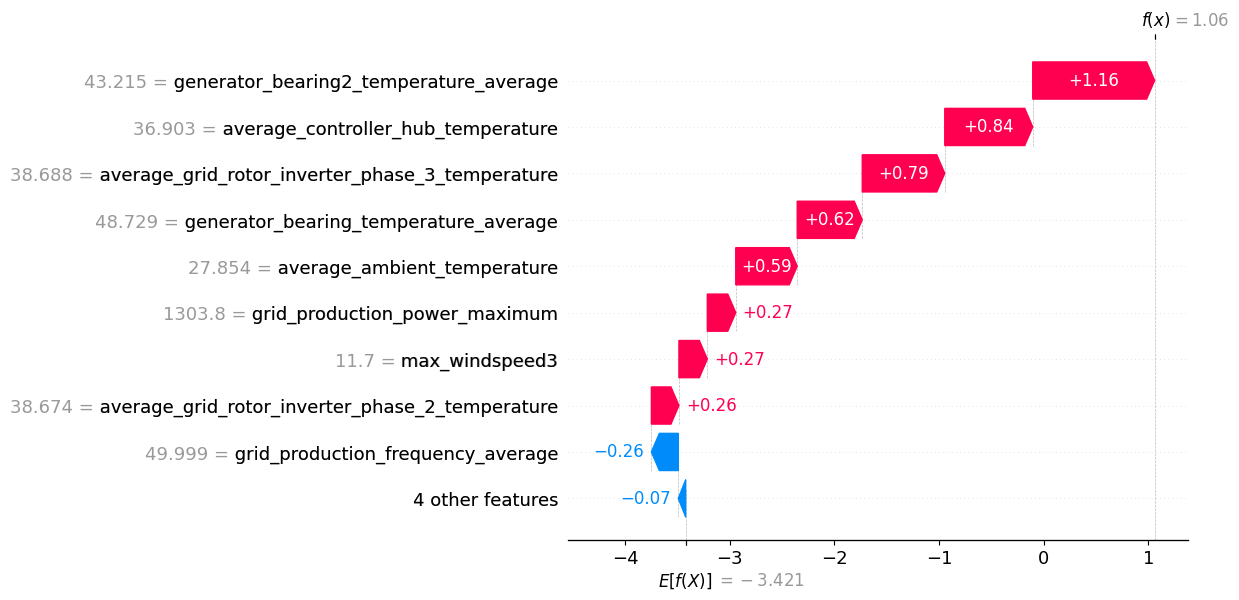

In [48]:

# Create an Explanation object
explainer = shap.TreeExplainer(models['GEARBOX'].named_steps['model'])
shap_values = explainer.shap_values(selected_features['GEARBOX'][1])
num_features = len(selected_features['GEARBOX'][2])
for i in range(num_features):
        feature_name = selected_features['GEARBOX'][2][i]
        print(f"{feature_name}: {shap_values[57][i]}")
shap_explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=selected_features['GEARBOX'][1])

shap.plots.waterfall(shap_explanation[57])


In [23]:
# print the whole number with e
print(f"{shap_values[0][1]:e}")
print(shap_values)
shap_values[1][6]

1.018951e-02
[[ 2.72958428e-02  1.01895072e-02 -1.93529651e-02 ...  4.68324006e-01
  -5.77600300e-01  3.87202948e-03]
 [-1.87305710e-03 -1.15916915e-01 -7.98486639e-04 ...  9.53081995e-02
  -3.89035717e-02 -8.76033232e-02]
 [-1.00979107e-02 -9.47475076e-01 -1.47788087e-04 ...  1.16284035e-01
  -6.08420670e-01 -3.73390019e-01]
 ...
 [-2.02578843e-01  6.70849502e-01  6.97022974e-02 ...  4.64041233e-01
  -5.65790012e-02  5.24279326e-02]
 [ 1.94237083e-02  4.37885642e-01  1.30950073e-02 ...  2.17175081e-01
   4.74278837e-01  1.78509690e-02]
 [ 7.42456131e-03 -1.47371614e+00 -1.53768063e-03 ... -1.29678041e-01
  -1.06159246e+00 -1.37171429e-02]]


-2.610803

In [49]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[57], selected_features['GEARBOX'][1].iloc[57])
#the graph is not showing all the features, it is showing only 7 features


In [4]:
classes = models['GEARBOX'].classes_.tolist()
classes

[0, 1]

In [2]:
import mlflow
mlflow.set_tracking_uri("http://localhost:80") 
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("predictive_maintenance_system")
    


experiment_id = experiment.experiment_id
runs = client.search_runs(experiment_ids=[experiment_id])
data = []
for run in runs:
        data.append({
            "Run ID": run.data.tags["mlflow.runName"],
            "F1 Score": run.data.metrics.get("score"),
            "Hyperparameters": run.data.params
        }) 
print(data)


[{'Run ID': 'TRANSFORMER', 'F1 Score': 0.9480572308904689, 'Hyperparameters': {'n_estimators': '50', 'max_depth': '80', 'learning_rate': '0.16002527282698065', 'max_features': '20'}}, {'Run ID': 'GENERATOR_BEARING', 'F1 Score': 0.9696340848604224, 'Hyperparameters': {'n_estimators': '100', 'max_depth': '40', 'learning_rate': '0.05738725558581813', 'max_features': '19'}}, {'Run ID': 'HYDRAULIC_GROUP', 'F1 Score': 0.8964187657682071, 'Hyperparameters': {'n_estimators': '200', 'max_depth': '80', 'learning_rate': '0.033460062769701523', 'max_features': '19'}}, {'Run ID': 'GENERATOR', 'F1 Score': 0.9221797301177146, 'Hyperparameters': {'n_estimators': '200', 'max_depth': '10', 'learning_rate': '0.0909594363986538', 'max_features': '20'}}, {'Run ID': 'GEARBOX', 'F1 Score': 0.9348200731743932, 'Hyperparameters': {'n_estimators': '100', 'max_depth': '20', 'learning_rate': '0.17209028508813332', 'max_features': '13'}}]


In [27]:
def get_data():
    failures = load_failures_data('../data/model_data/failures.csv')
    components = failures['component'].unique()
    component_data = load_all_component_data(components)
    data_splits, ui_data_splits = prepare_all_data_for_training(component_data, "target_class")
    models = load_all_models(components, "xgb")
    selected_features_data = fit_and_select_features(models, data_splits)
    models = retrain_models_on_selected_features(models, selected_features_data, data_splits)
    
    for component in components:
        # Predict and assign the class label
        y_predict = models[component].predict(selected_features_data[component][1])
        selected_features_data[component][1]['target_class'] = y_predict
        selected_features_data[component][1]['target_class'] = selected_features_data[component][1]['target_class']
        
        # Assign turbine_id and convert timestamps
        selected_features_data[component][1]['turbine_id'] = ui_data_splits[component][1]['turbine_id']
        print(type(ui_data_splits[component][1]['turbine_id'] ))
        ui_data_splits[component][1]['timestamp'] = pd.to_datetime(ui_data_splits[component][1]['timestamp'])
        
        
        # Convert to datetime and extract the date
        selected_features_data[component][1]['timestamp'] = ui_data_splits[component][1]['timestamp']
    return selected_features_data, components


In [28]:
selected_features,component = get_data()

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [29]:
#print the instances qithselected_features['GEARBOX'][1]['target_class'] == 1
#print(selected_features['GEARBOX'][1][selected_features['GEARBOX'][1]['target_class'] == 1])
#print the index of the instances with selected_features['GEARBOX'][1]['target_class'] == 1
print(selected_features['GEARBOX'][1][selected_features['GEARBOX'][1]['target_class'] == 1].index)

Int64Index([1131, 229, 495, 1116, 1128, 497, 1078, 522, 802, 1091, 231, 755,
            1117, 185, 115],
           dtype='int64')


In [39]:
selected_features['GEARBOX'][1].reset_index(drop=True, inplace=True)

In [40]:
# print the index of the instances with selected_features['GEARBOX'][1]['target_class'] == 1
print(selected_features['GEARBOX'][1][selected_features['GEARBOX'][1]['target_class'] == 1].index)


Int64Index([26, 57, 118, 181, 190, 234, 253, 356, 392, 415, 428, 472, 561, 563,
            639],
           dtype='int64')


In [49]:
def is_faulty(turbine_id, date_selected, component_data):
    # Convert component data to records for iteration
    for record in component_data.to_dict('records'):
        # Check if turbine_id and date match, and if target_class is 1 (indicating a fault)
        if (record['turbine_id'] == turbine_id and 
            record['timestamp'] == date_selected and 
            record['target_class'] == 1):
            return True
    return False


In [50]:
faulty = is_faulty('T07', '2017-09-05', selected_features['GEARBOX'][1])

In [18]:
turnin_id = selected_features['GEARBOX'][1]['turbine_id']
date = pd.to_datetime(selected_features['GEARBOX'][1]['timestamp'])

In [31]:
date_col = pd.to_datetime(selected_features['GEARBOX'][1]['timestamp'])
date_col = date_col.dt.date

In [13]:
def select_features(models, data_splits):
    selected_features_data = {}
    for component, model in models.items():
        X_train, X_test, y_train, y_test = data_splits[component]
        model.fit(X_train, y_train)
        selector =  model.named_steps['feature_selection']
        selected_features = X_train.columns[selector.get_support()]
        selected_features_train = X_train[selected_features]
        selected_features_train.reset_index(drop=True, inplace=True)
        selected_features_test = X_test[selected_features]
        selected_features_test.reset_index(drop=True, inplace=True)
        selected_features_data[component] = (selected_features_train, selected_features_test, selected_features)
    return selected_features_data

In [14]:
selected_features = select_features(models, data_splits)

In [5]:
for component in components:
    globals()[f"{component}_X_train"] = selected_features[component][0]
    globals()[f"{component}_X_test"] = selected_features[component][1]
    globals()[f"{component}_y_train"] = data_splits[component][2]
    globals()[f"{component}_y_test"] = data_splits[component][3]

In [6]:
for component in components:
    models[component].fit(selected_features[component][0] ,globals()[f"{component}_y_train"])

In [7]:
# confusion matrix
from sklearn.metrics import confusion_matrix

for component in components:
    globals()[f"{component}_y_pred"] = models[component].predict(selected_features[component][1])
    globals()[f"{component}_conf_matrix"] = confusion_matrix(globals()[f"{component}_y_test"], globals()[f"{component}_y_pred"])
    print(globals()[f"{component}_conf_matrix"])

[[679  10]
 [ 36   4]]
[[639  12]
 [ 44  34]]
[[617  17]
 [ 60  35]]
[[688   8]
 [ 18  15]]
[[659  18]
 [ 23  29]]


In [8]:
def train_run(X, y, X_valid, y_valid, model):
    clf = model
    clf.fit(X, y)
    y_valid_pred = clf.predict(X_valid)
    y_train_pred = clf.predict(X)
    f1_train = f1_score(y, y_train_pred, average="weighted")
    precision_train = precision_score(y, y_train_pred, average="weighted")
    recall_train = recall_score(y, y_train_pred, average="weighted")
    f1 = f1_score(y_valid, y_valid_pred, average="weighted")
    precision = precision_score(y_valid, y_valid_pred, average="weighted")
    recall = recall_score(y_valid, y_valid_pred, average="weighted")

    scores = {
        "f1_train": f1_train,
        "precision_train": precision_train,
        "recall_train": recall_train,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

    return scores

In [9]:
for component in components:
    globals()[f"{component}_scores"] = train_run(selected_features[component][0], globals()[f"{component}_y_train"], selected_features[component][1], globals()[f"{component}_y_test"], models[component])
    print(f"{component}_scores: {globals()[f'{component}_scores']}")

GEARBOX_scores: {'f1_train': 1.0, 'precision_train': 1.0, 'recall_train': 1.0, 'f1': 0.9222933495910178, 'precision': 0.9132203872944614, 'recall': 0.9368998628257887}
GENERATOR_scores: {'f1_train': 1.0, 'precision_train': 1.0, 'recall_train': 1.0, 'f1': 0.9141918487192088, 'precision': 0.9145592144368501, 'recall': 0.9231824417009602}
HYDRAULIC_GROUP_scores: {'f1_train': 1.0, 'precision_train': 1.0, 'recall_train': 1.0, 'f1': 0.8806596320227418, 'precision': 0.8803199427549775, 'recall': 0.8943758573388203}
GENERATOR_BEARING_scores: {'f1_train': 1.0, 'precision_train': 1.0, 'recall_train': 1.0, 'f1': 0.9612774980899882, 'precision': 0.9599131641118201, 'recall': 0.9643347050754458}
TRANSFORMER_scores: {'f1_train': 1.0, 'precision_train': 1.0, 'recall_train': 1.0, 'f1': 0.9424417963921411, 'precision': 0.9413631386609856, 'recall': 0.943758573388203}
